Before we begin, we will change a few settings to make the notebook look a bit prettier:

In [1]:
%%html
<style> body {font-family: "Calibri", cursive, sans-serif;} </style>

<img src="../images/pokeball.png" width="100" align="right">

# Visualization of the<br> Favorite Pok&eacute;mon Survey Results
---
In this notebook, I will generate different visualizations of the [Favorite Pok&eacute;mon Survey](<https://www.reddit.com/r/pokemon/comments/c04rvq/survey_testing_the_every_pok%C3%A9mon_is_someones/>) results. The data was collected and made public by [reddit user mamamia1001](https://www.reddit.com/user/mamamia1001/). Full credit goes to him/her. I will also be including a few comments on the results and how I interpret them. For more info, take a look at the [README file](../README.md). 

Alright, let's get started.


# Preliminaries
First, let's import all the relevant packages, configure some plotting options, and define some basic (path) variables.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pathlib
from PIL import Image
import requests
from io import BytesIO

In [3]:
mpl.rcParams['font.sans-serif'] = 'Calibri'
mpl.rcParams['font.family'] = 'sans-serif'
sns.set(font_scale=1.75)
sns.set(font = 'Calibri')
sns.set_style('ticks')

plt.rc('axes.spines', top=False, right=False)

# Control font sizes.
plt.rc('font', size=12) # Default text size
plt.rc('axes', titlesize=16) # Axes title
plt.rc('axes', labelsize=16) # x and y labels
plt.rc('xtick', labelsize=12) # x tick labels
plt.rc('ytick', labelsize=12) # y tick labels
plt.rc('legend', fontsize=12) # Legend
plt.rc('figure', titlesize=16) # Figure title

In [4]:
# Define paths.
PATH_DATA = pathlib.Path(r'../data')
PATH_IMAGES = pathlib.Path(r'../images')

# Read data
I [downloaded a copy](../data) of the [original results](https://docs.google.com/spreadsheets/d/1c16Wh4AawHGbTi3Eq1DGZQdM4FMUlJO1YwXJZ_ylRvg/edit#gid=557303698) as an Excel file. Let's read just the relevant parts:

In [5]:
df = pd.read_excel(PATH_DATA/'responses.xlsx', sheet_name='Results', usecols='A:E')
df.rename(columns={'Results in full':'name', 'Unnamed: 1':'votes', 'Unnamed: 2':'types', 'Unnamed: 3':'generation', 'Unnamed: 4':'family'}, inplace=True)

# Shift the index by 1, so that it matches the Pokemon number.
df.index = df.index + 1

# Remove any potential NaN.
df.dropna(inplace=True)

# Make sure generation is int.
df['generation'] = df['generation'].astype(int)

df.head(3)

,name,votes,types,generation,family
1,Bulbasaur,710.0,Grass Poison,1,Bulbasaur
2,Ivysaur,83.0,Grass Poison,1,Bulbasaur
3,Venusaur,127.0,Grass Poison,1,Bulbasaur


# Original Analysis
As a sanity check, let's (re)compute the already reported numbers.

### Number of valid votes
Original result: 52725

From the aggregated results:

In [6]:
n_votes = df['votes'].sum()
print(n_votes)

52725.0


### Average votes per Pok&eacute;mon
Original result: 65

In [7]:
n_pokemon = len(df['name'].unique())
print(n_votes/n_pokemon)

65.17305315203956


### Average votes per Pok&eacute;mon per generation

In [8]:
df_votes_generation = df.groupby(['generation']).mean()
print(df_votes_generation)

                 votes
generation            
1           121.119205
2            91.150000
3            70.140741
4            70.383178
5            28.147436
6            29.916667
7            20.181818


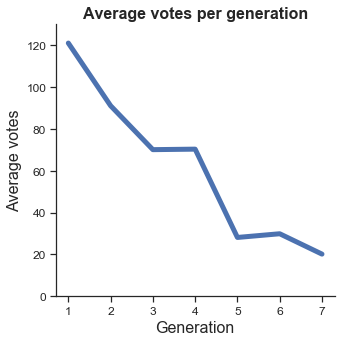

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
ax.plot(df_votes_generation.index, df.groupby(['generation']).mean()['votes'], linewidth=5)
ax.set_xticks(df_votes_generation.index)
ax.set_ylim((0, 130))
ax.set_title("Average votes per generation", fontdict = {'weight':'bold'})
ax.set_xlabel("Generation")
ax.set_ylabel("Average votes")
plt.show()

Generation colors were taken from [Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/Generation).

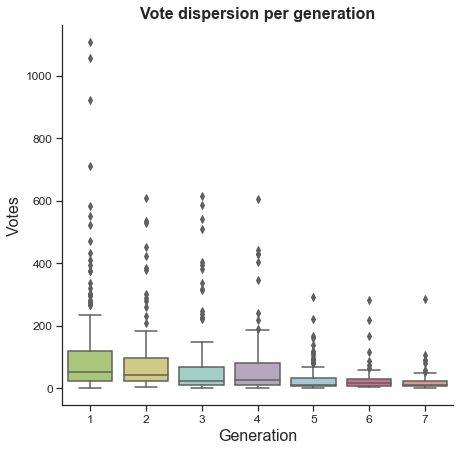

In [10]:
generation_palette = {1:'#ACD36C', 
                      2:'#DCD677', 
                      3:'#9CD7C8', 
                      4:'#B7A3C3', 
                      5:'#9FCADF', 
                      6:'#DD608C', 
                      7:'#E89483'}

fig, ax = plt.subplots(1, 1, figsize=[7, 7])
sns.boxplot(x='generation', y='votes', data=df, ax=ax, palette=generation_palette)
ax.set_title("Vote dispersion per generation", fontdict = {'weight':'bold'})
ax.set_xlabel("Generation")
ax.set_ylabel("Votes")
plt.show()

The outliers show us Pok&eacute;mon with a high number of votes. As we will see in a second, it is clear that no Pok&eacute;mon from generations 5, 6, or 7 cracks the top preference spots.

### Pok&eacute;mon ranking
Sort Pok&eacute;mon from most to least popular:

In [11]:
df_sorted = df.sort_values('votes', ascending=False)

The top 10 (most popular) Pok&eacute;mon:

In [12]:
df_sorted.head(10)

,name,votes,types,generation,family
6,Charizard,1107.0,Fire Flying Dragon,1,Charmander
94,Gengar,1056.0,Ghost Poison,1,Gastly
59,Arcanine,923.0,Fire,1,Growlithe
1,Bulbasaur,710.0,Grass Poison,1,Bulbasaur
257,Blaziken,613.0,Fire Fighting,3,Torchic
197,Umbreon,607.0,Dark,2,Eevee
448,Lucario,604.0,Fighting Steel,4,Riolu
282,Gardevoir,585.0,Psychic Fairy,3,Ralts
133,Eevee,581.0,Normal,1,Eevee
149,Dragonite,551.0,Dragon Flying,1,Dratini


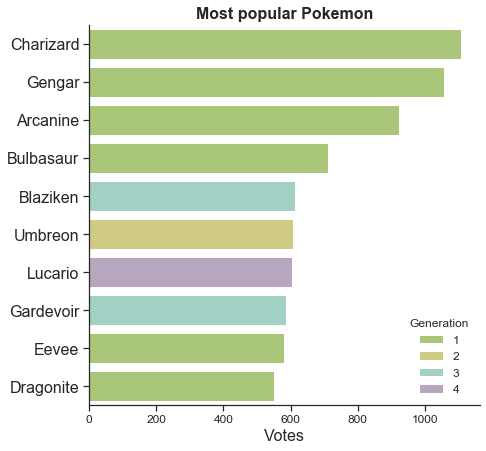

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[7, 7])
sns.barplot(x=df_sorted.head(10)['votes'], y=df_sorted.head(10)['name'], hue='generation', palette=generation_palette, dodge=False, data=df_sorted.head(10), ax=ax)
ax.set_title("Most popular Pokemon", fontdict={'weight':'bold'})
ax.set_xlabel("Votes")
ax.set_ylabel("")
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(frameon=False, loc='lower right').set_title("Generation")
plt.show()

Now we know who were those outliers from earlier ;) .

### Pok&eacute;mon ranking by family
The top 10 (most popular) Pok&eacute;mon *families*:

In [14]:
df_families = df[['votes', 'family']].groupby(['family']).sum().sort_values('votes', ascending=False).head(10)
df_families

,votes
family,
Eevee,2865.0
Charmander,1551.0
Gastly,1384.0
Growlithe,1199.0
Cyndaquil,1092.0
Squirtle,1066.0
Ralts,924.0
Bulbasaur,920.0
Scyther,818.0


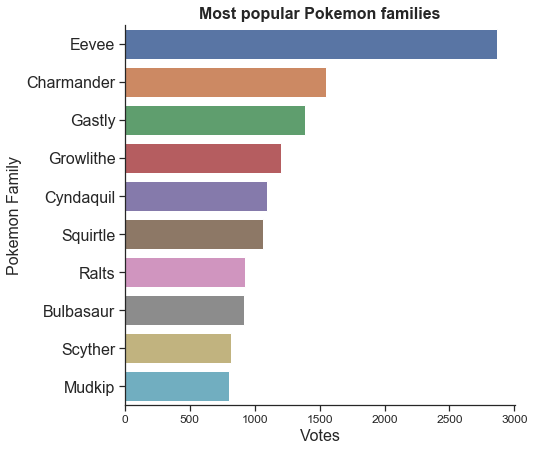

In [15]:
fig, ax = plt.subplots(1, 1, figsize=[7, 7])
sns.barplot(x=df_families['votes'], y=df_families.index, data=df_families, ax=ax)
ax.set_title("Most popular Pokemon families", fontdict={'weight':'bold'})
ax.set_xlabel("Votes")
ax.set_ylabel("Pokemon Family")
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

### Pok&eacute;mon ranking by generation
The most popular Pok&eacute;mon of each generation:

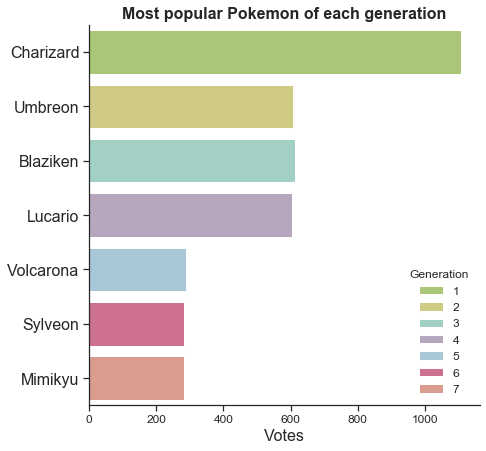

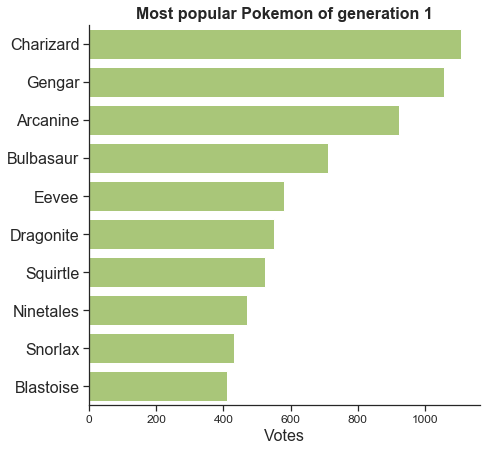

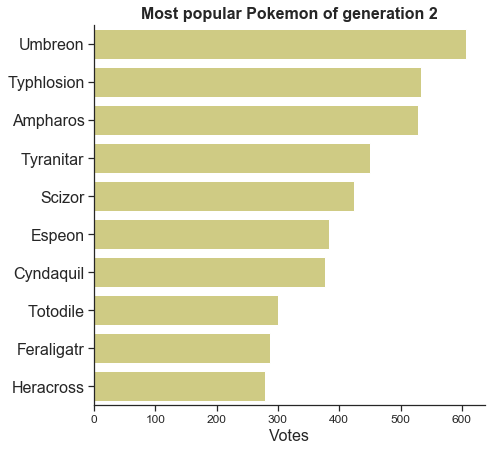

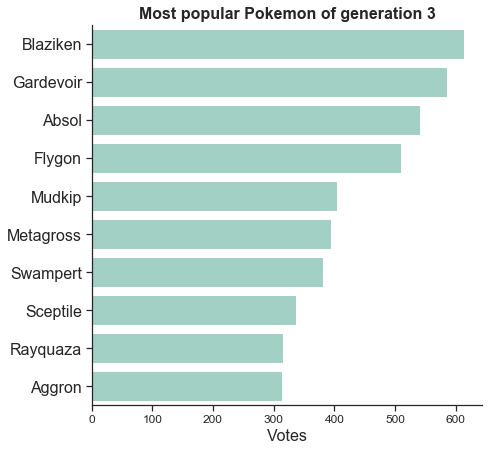

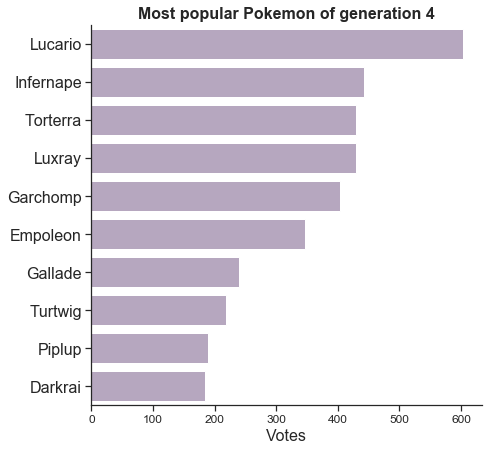

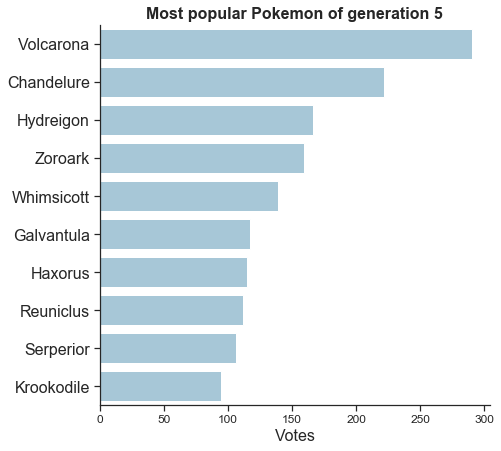

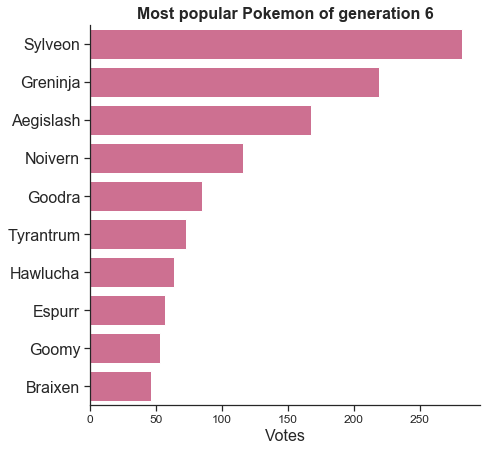

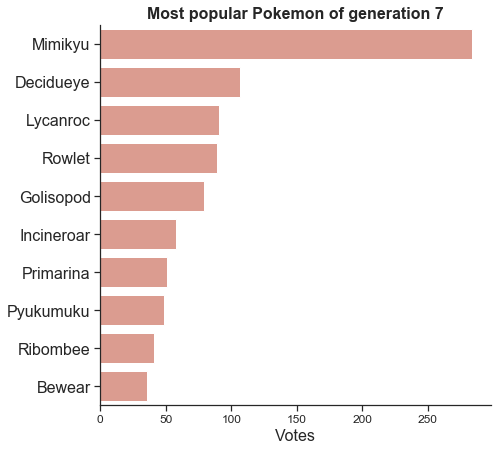

In [16]:
generations = list(df['generation'].unique().astype(int))
generations.insert(0, 'all')

for generation in generations:
    if generation == 'all':
        idx = df.groupby('generation')['votes'].transform(max) == df['votes']
        df_generation = df[idx]
        title_str = "each generation"

    else:
        df_temp = df.query('generation == "' + str(generation) + '"')
        df_generation = df_temp.sort_values('votes', ascending=False).head(10)
        title_str = "generation " + str(generation)
    
    fig, ax = plt.subplots(1, 1, figsize=[7, 7])
    sns.barplot(x=df_generation['votes'], y=df_generation['name'], hue='generation', palette=generation_palette, dodge=False, data=df_generation, ax=ax)
    if generation == 'all':
        ax.legend(frameon=False, loc='lower right').set_title("Generation")
    else:
        ax.get_legend().remove()
    ax.set_title("Most popular Pokemon of " + title_str, fontdict={'weight':'bold'})
    ax.set_xlabel("Votes")
    ax.set_ylabel("")
    ax.yaxis.set_tick_params(labelsize=16)
    plt.show()


### Pok&eacute;mon ranking by type
For this, we will need to do a bit of processing. First, we will make sure that each Pok&eacute;mon has unique types (i.e., that its types are not repeated).

In [17]:
def types_unique(types):
    if type(types)==str:
        types_set = set(types.lower().split())
        return ' '.join(types_set)
    else:
        return types
df_sorted['types'] = df_sorted['types'].apply(types_unique)

After that, we will split each type into a different column:

In [18]:
n_types = 3
types_all = df_sorted['types'].str.split(" ", n=n_types, expand = True)

for ii in np.arange(0, n_types):
    column_name = 'type' + str(ii+1)
    df_sorted[column_name] = types_all[ii]


Now, we can do an analysis per type. Consider that Alolan versions might have different types for the same Pok&eacute;mon (e.g., Vulpix is fire type, while Alolan Vulpix is ice). In this case, we are considering only the main (i.e., first) type of each Pok&eacute;mon:

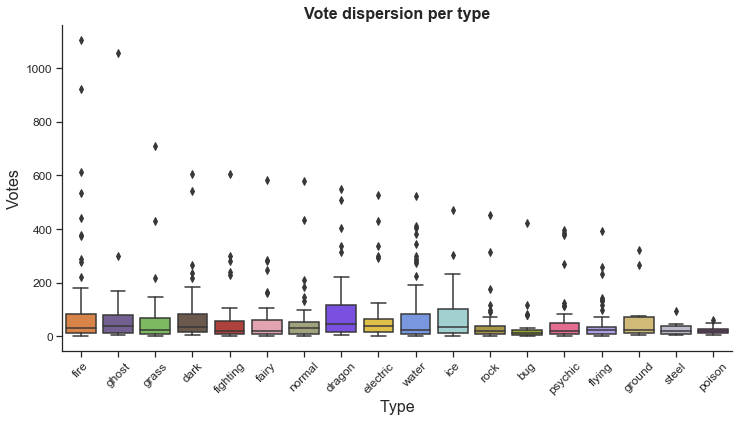

In [19]:
type_palette = {'normal':'#A8A878',
              'fire':'#F08030',
              'fighting':'#C03028',
              'water':'#6890F0',
              'flying':'#A890F0',
              'grass':'#78C850',
              'poison':'#A040A0',
              'electric':'#F8D030',
              'ground':'#E0C068',
              'psychic':'#F85888',
              'rock':'#B8A038',
              'ice':'#98D8D8',
              'bug':'#A8B820',
              'dragon':'#7038F8',
              'ghost':'#705898',
              'dark':'#705848',
              'steel':'#B8B8D0',
              'fairy':'#EE99AC'}

fig, ax = plt.subplots(1, 1, figsize=[12, 6])
sns.boxplot(x='type1', y='votes', data=df_sorted, ax=ax, palette=type_palette)
ax.set_title("Vote dispersion per type", fontdict = {'weight':'bold'})
ax.set_xlabel("Type")
ax.set_ylabel("Votes")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In this case, we are considering *all* the types of a Pok&eacute;mon:

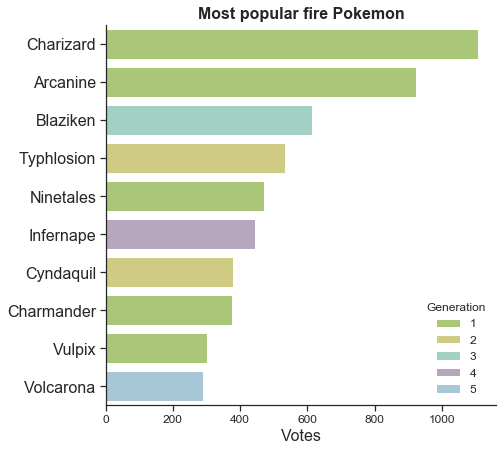

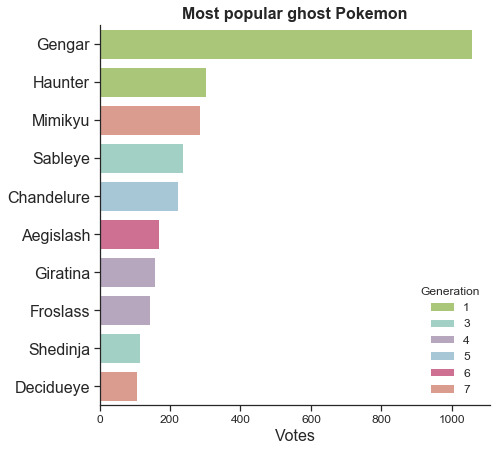

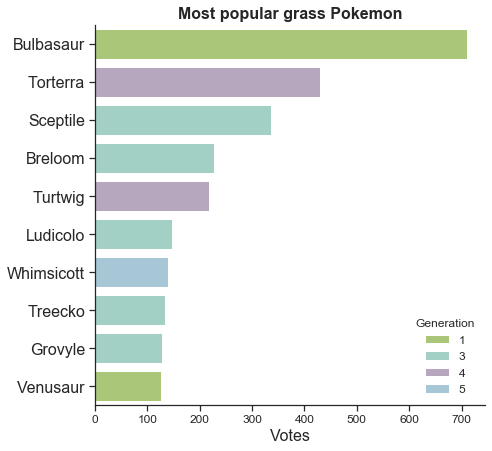

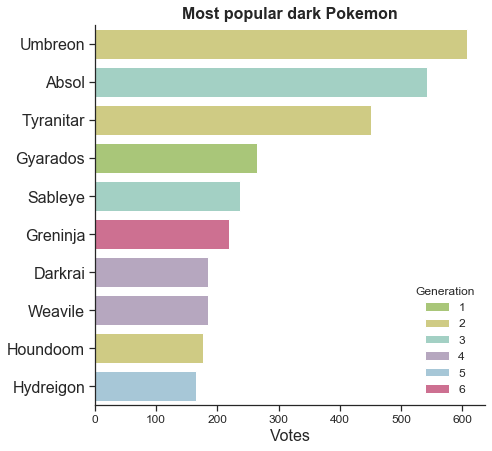

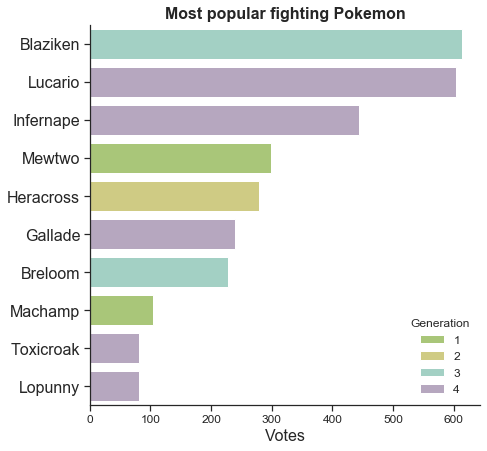

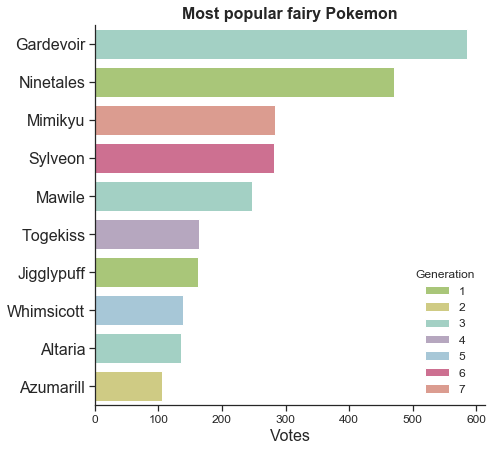

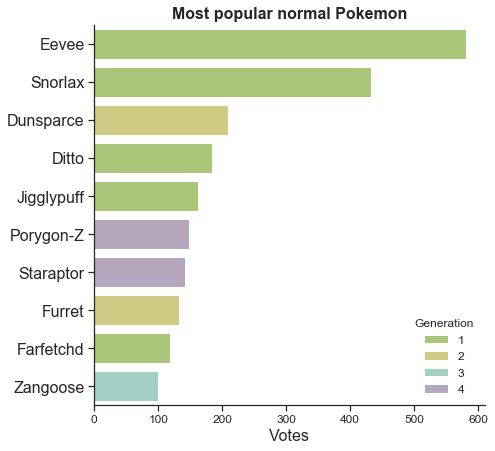

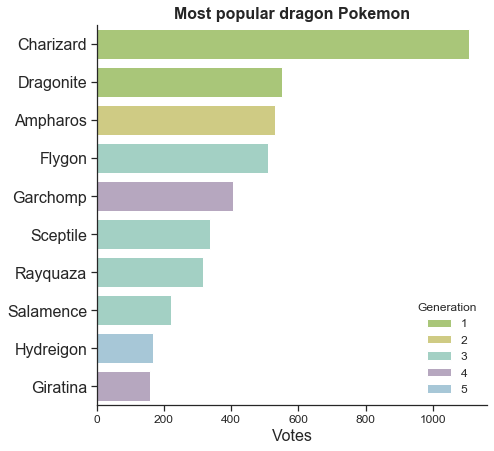

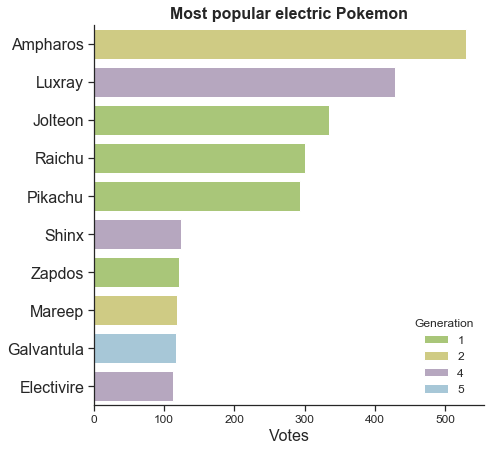

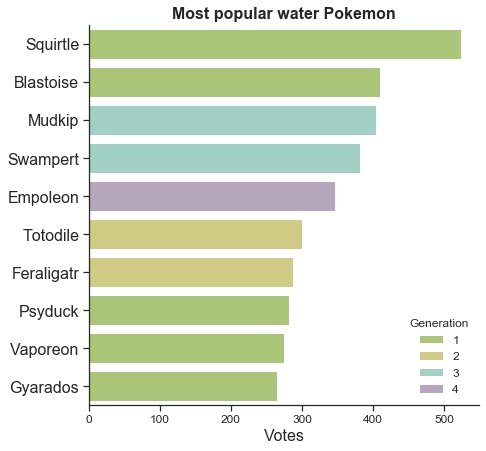

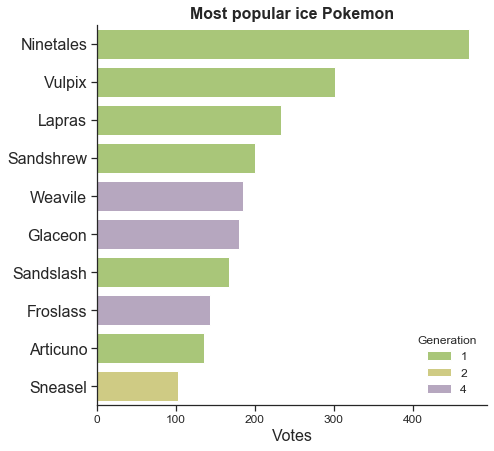

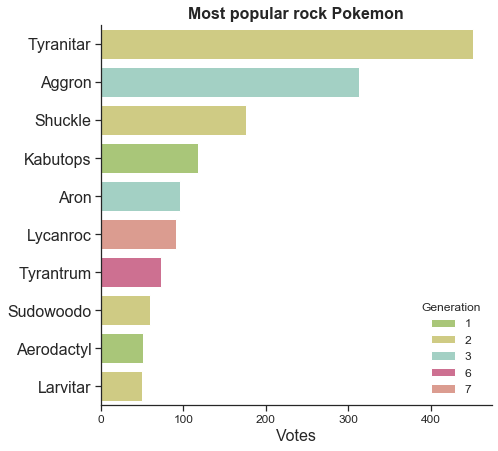

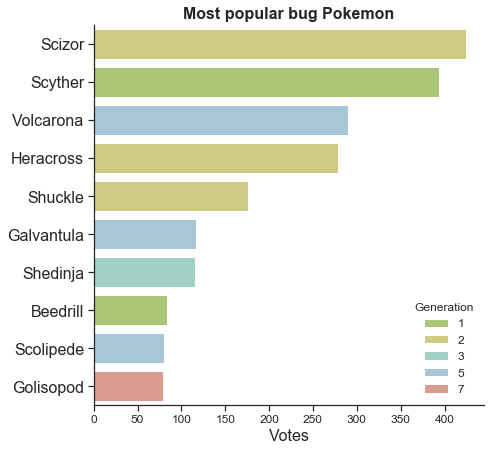

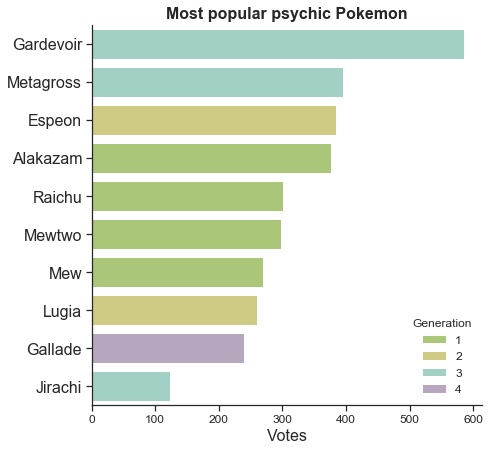

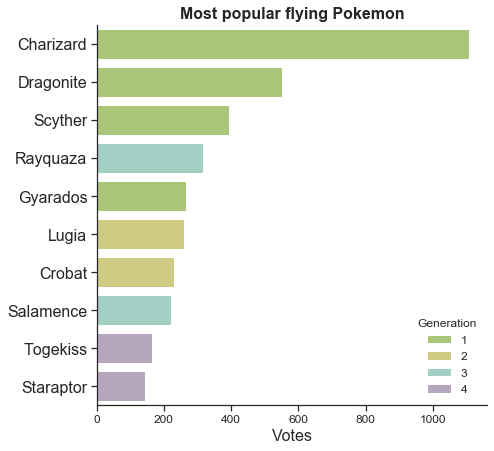

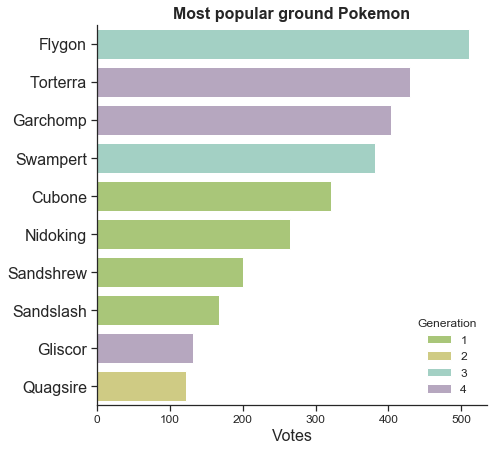

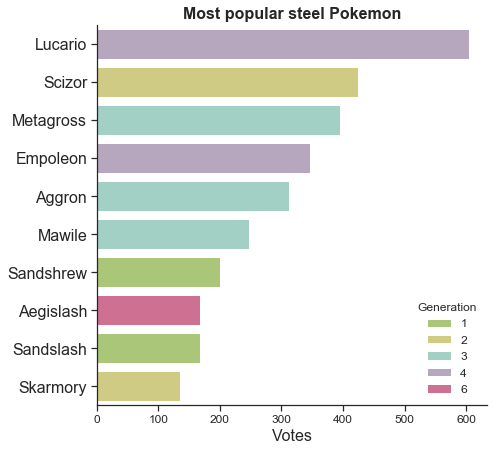

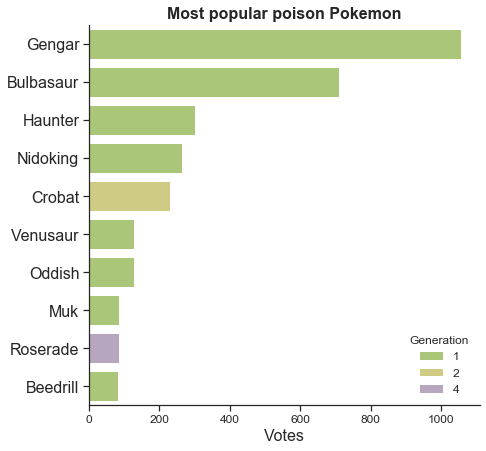

In [20]:
types = df_sorted['type1'].unique()
for pokemon_type in types:
    df_temp = df_sorted.query('type1=="' + pokemon_type + '" | type2=="' + pokemon_type + '" | type3=="' + pokemon_type + '"')
    df_temp.head(10)
    
    fig, ax = plt.subplots(1, 1, figsize=[7, 7])
    sns.barplot(x=df_temp.head(10)['votes'], y=df_temp.head(10)['name'], hue='generation', palette=generation_palette, dodge=False, data=df_temp.head(10), ax=ax)
    ax.set_title("Most popular " + pokemon_type + " Pokemon", fontdict={'weight':'bold'})
    ax.set_xlabel("Votes")
    ax.set_ylabel("")
    ax.yaxis.set_tick_params(labelsize=16)
    ax.legend(frameon=False, loc='lower right').set_title("Generation")
    plt.show()

### Least loved Pok&eacute;mon
The least popular Pok&eacute;mon. Those who received 0 votes:

In [21]:
df_sorted.query('votes == 0')

,name,votes,types,generation,family,type1,type2,type3
574,Gothita,0.0,psychic,5,Gothita,psychic,None,None
603,Eelektrik,0.0,electric,5,Tynamo,electric,None,None
266,Silcoon,0.0,bug,3,Wurmple,bug,None,None
734,Yungoos,0.0,normal,7,Yungoos,normal,None,None


...and those who received 1 vote:

In [22]:
df_sorted.query('votes == 1')

,name,votes,types,generation,family,type1,type2,type3
540,Sewaddle,1.0,grass bug,5,Sewaddle,grass,bug,None
594,Alomomola,1.0,water,5,Alomomola,water,None,None
790,Cosmoem,1.0,psychic,7,Cosmog,psychic,None,None
343,Baltoy,1.0,psychic ground,3,Baltoy,psychic,ground,None
451,Skorupi,1.0,bug poison,4,Skorupi,bug,poison,None
732,Trumbeak,1.0,flying normal,7,Pikipek,flying,normal,None
102,Exeggcute,1.0,grass psychic,1,Exeggcute,grass,psychic,None
504,Patrat,1.0,normal,5,Patrat,normal,None,None


The bottom 10 (least popular) Pok&eacute;mon *families*:

In [23]:
df[['votes', 'family']].groupby('family').sum().sort_values('votes', ascending=False).tail(10)

# Notice that a similar result could be achieved by using
# df[['votes', 'family']].groupby('family').sum().sort_values('votes', ascending=True).head(10)

,votes
family,
Virizion,4.0
Thundurus,4.0
Uxie,3.0
Terrakion,3.0
Tapu-Bulu,2.0
Tapu-Fini,2.0
Phione,2.0
Tornadus,2.0
Landorus,2.0


### Paretto analysis
`mamamia1001` also generated a plot of the [Paretto principle](https://en.wikipedia.org/wiki/Pareto_principle) (also known as the 80/20 rule). Originally, it states that roughly 80% of the effects (in this case, votes) come from 20% of the causes (in this case, Pok&eacute;mon). Let's obtain such plot. 

First, let's compute the cumulative sum of votes and their corresponding vote percentage for each Pok&eacute;mon:

In [24]:
df_paretto = df_sorted.copy()
df_paretto['votes_cumulative'] = df_sorted['votes'].cumsum()
df_paretto['votes_cumulative_perc'] = (df_paretto['votes_cumulative']/n_votes) * 100

We just need to generate a few auxiliary variables to generate the plot:

In [25]:
df_paretto['pokemon_perc'] = (np.arange(1, n_pokemon+1)/n_pokemon)*100

# Find the index of the Pokemon corresponding to the 20% of the Pokemon.
index_pokemon_20 = abs(df_paretto['pokemon_perc'] - 20).idxmin()

# Find the index and value of the Pokemon corresponding to the 80% of the votes.
pokemon_votes_80_idx = abs(df_paretto['votes_cumulative_perc'] - 80).idxmin()
pokemon_votes_80 = df_paretto.loc[pokemon_votes_80_idx, 'pokemon_perc']

# Find the index and value of the votes corresponding to the 20% of the Pokemon
votes_pokemon_20_idx = abs(df_paretto['pokemon_perc'] - 20).idxmin()
votes_pokemon_20 = df_paretto.loc[votes_pokemon_20_idx, 'votes_cumulative_perc']

# Find the index of the votes corresponding to the 80% of the votes.
index_votes_80 = abs(df_paretto['votes_cumulative_perc'] - 80).idxmin()


Actually generate the Paretto plot:

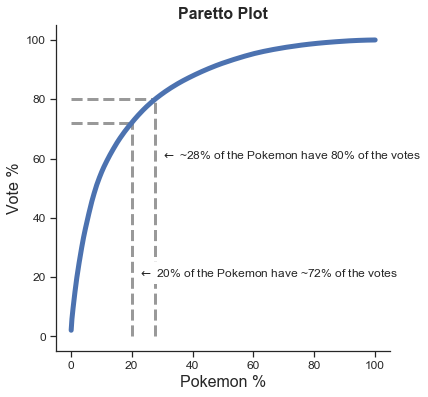

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.plot(df_paretto['pokemon_perc'], df_paretto['votes_cumulative_perc'], linewidth=5)

plt.hlines(80, 0, pokemon_votes_80, linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])
plt.hlines(votes_pokemon_20, 0, df_paretto.loc[index_pokemon_20, 'pokemon_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])

plt.vlines(20, 0, df_paretto.loc[index_pokemon_20, 'votes_cumulative_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])
plt.vlines(df_paretto.loc[index_votes_80, 'pokemon_perc'], 0, df_paretto.loc[index_votes_80, 'votes_cumulative_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])

plt.text(22, 20, r"$\leftarrow$ 20% of the Pokemon have ~{0:.0f}% of the votes".format(votes_pokemon_20), fontsize=12, backgroundcolor='w')
plt.text(pokemon_votes_80+2, 60, r"$\leftarrow$ ~{0:.0f}% of the Pokemon have 80% of the votes".format(pokemon_votes_80), fontsize=12, backgroundcolor='w')

ax.set_title("Paretto Plot", fontdict = {'fontsize':16, 'fontweight':'bold'})
ax.set_xlabel("Pokemon %", fontdict = {'fontsize':16})
ax.set_ylabel("Vote %", fontdict = {'fontsize':16})

plt.show()

# New Analysis
Alright, time to go to uncharted territory. Fasten your Pok&eacute;seat belts.

### Votes in time
First, I would like to look at how people voted in time overall and for each of the top Pok&eacute;mon:

In [27]:
df_raw = pd.read_excel(PATH_DATA/'responses.xlsx', sheet_name='Form Responses 1')
df_raw.rename(columns={'Timestamp':'timestamp', 'What is your favourite Pokémon?':'vote'}, inplace=True)

# Remove any potential NaN.
df_raw.dropna(inplace=True)

df_raw.head(3)

,timestamp,vote
0,2019-06-13 13:02:02.242,Munchlax
1,2019-06-13 12:44:00.726,Type-Null
2,2019-06-13 12:44:45.607,Giratina


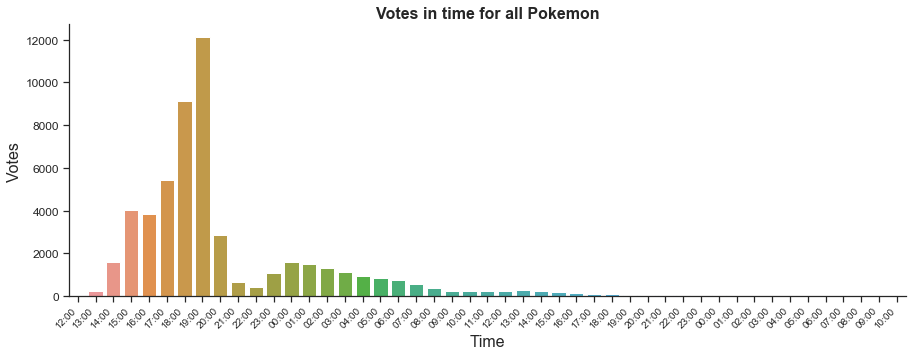

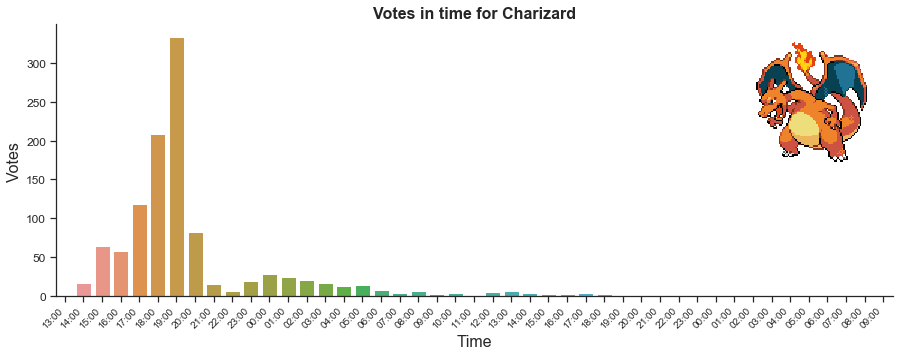

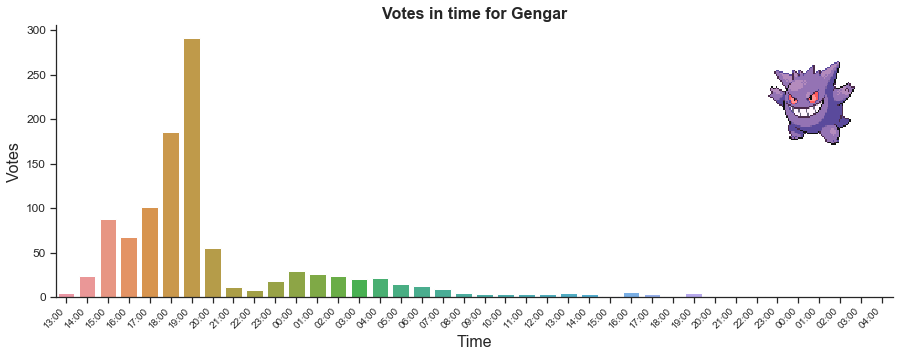

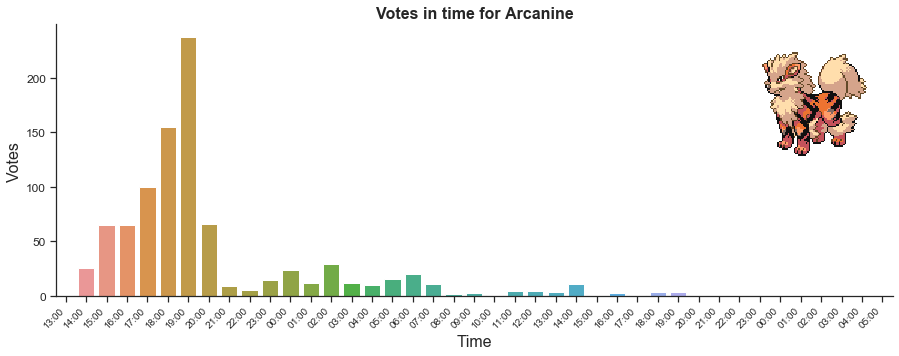

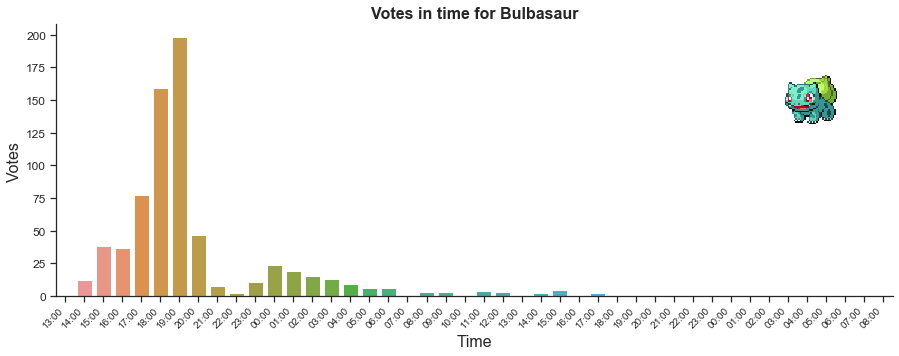

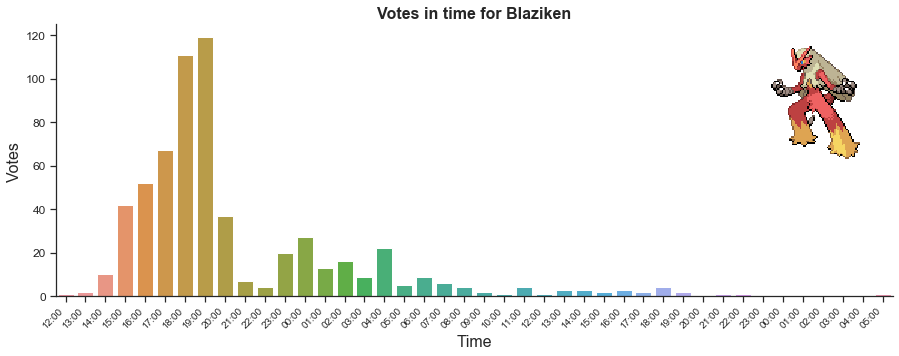

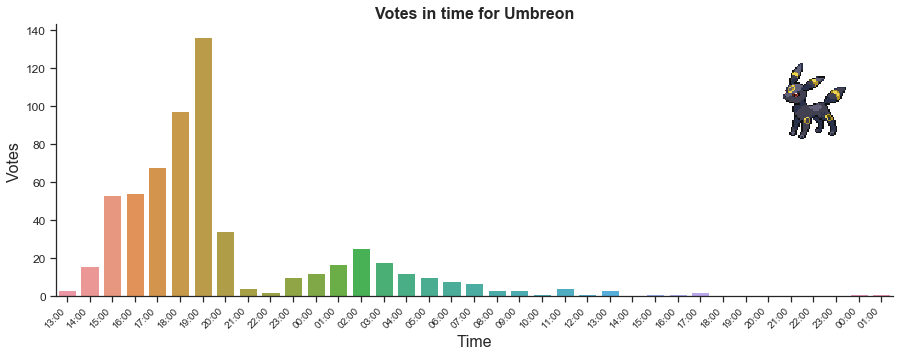

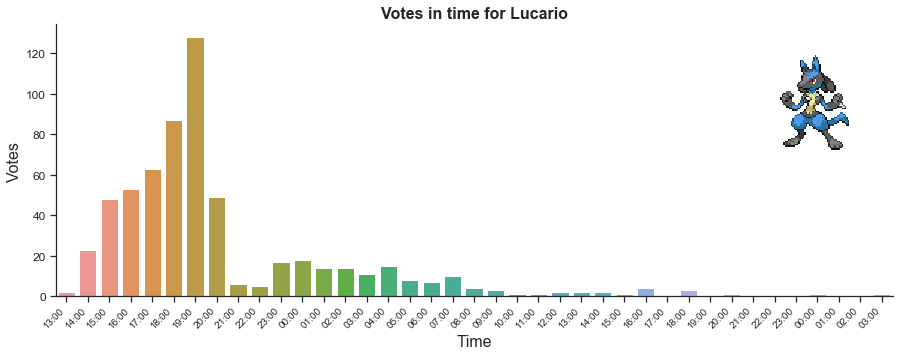

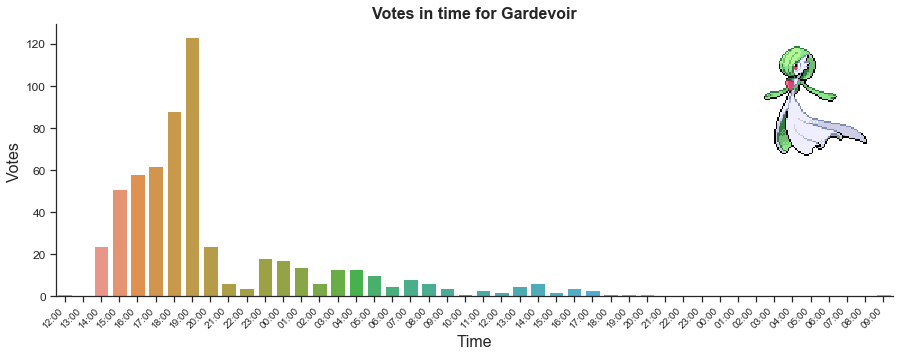

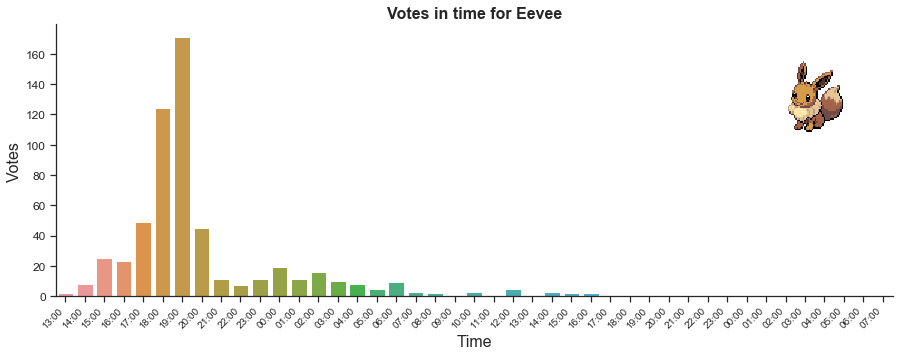

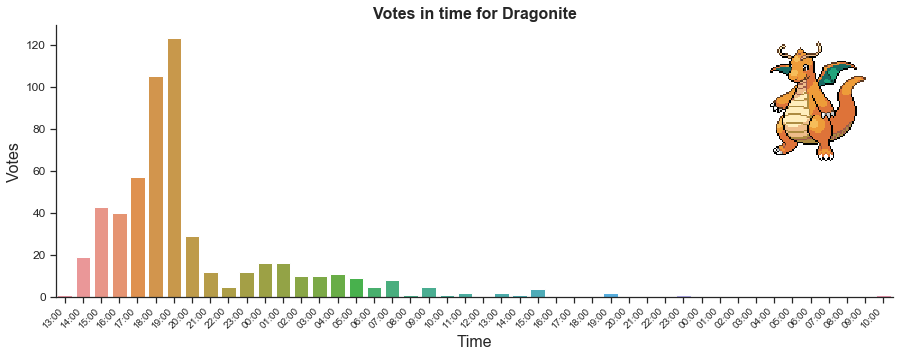

In [28]:
pokemon_time = list(df_sorted.head(10)['name'])
pokemon_number_time = list(df_sorted.head(10).index)

pokemon_time.insert(0, 'all')
pokemon_number_time.insert(0, 0)

for pokemon, pokemon_number in zip(pokemon_time, pokemon_number_time):
    
    if pokemon == 'all':
        df_temp = df_raw.copy(deep=True)
        title_str = "all Pokemon"
    else:
        df_temp = df_raw.query('vote=="' + pokemon + '"')
        title_str = pokemon
        
    df_time = df_temp.groupby(pd.Grouper(key='timestamp', freq='1h')).count()
    df_time['timestamp'] = df_time.index

    x_times = df_time['timestamp'].dt.strftime('%H:%M')
                   
    fig, ax = plt.subplots(1, 1, figsize=[15, 5])
    sns.barplot(x='timestamp', y='vote', data=df_time, ax=ax)
    ax.set_title("Votes in time for " + title_str, fontdict={'weight':'bold'})
    ax.set_xticklabels(labels=x_times, rotation=45, ha='right', fontdict = {'fontsize':10})
    ax.set_xlabel("Time")
    ax.set_ylabel("Votes")
    
    # If the plot correspond to a specific Pokemon, include its image.
    if pokemon_number != 0:
        
        # We will get the Pokemon sprite using PokeAPI (https://pokeapi.co/)
        pokemon_url = 'https://pokeapi.co/api/v2/pokemon/' + str(pokemon_number) + '/'
        pokemon_response = requests.get(pokemon_url)
        if (pokemon_response.status_code >= 200) & (pokemon_response.status_code <= 299):
            pokemon_json = pokemon_response.json()
            pokemon_image_url = pokemon_json['sprites']['front_default']
            pokemon_image_response = requests.get(pokemon_image_url)
            if (pokemon_image_response.status_code >= 200) & (pokemon_image_response.status_code <= 299):
                pokemon_image = Image.open(BytesIO(pokemon_image_response.content))
                ax_ins = inset_axes(ax, width=2, height=2, loc='upper right')
                ax_ins.imshow(pokemon_image)
                ax_ins.axis('off')
    plt.show()

It looks like votes for each of the top Pok&eacute;mon were more or less cast in the same way than for all other Pok&eacute;mon.

### Incorporating Pok&eacute;mon stats
I'm very curious to see if Pok&eacute;mon stats have some influence on their popularity. To do so, I will use ["The Complete Pokemon Dataset"](https://www.kaggle.com/rounakbanik/pokemon) (from Kaggle). You will find the corresponding [.csv file here](../data).

In [29]:
df_stats_ = pd.read_csv(PATH_DATA/'pokemon_stats.csv')
df_stats = df.merge(df_stats_[['pokedex_number', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'height_m', 'weight_kg']], how='left',left_index=True, right_on='pokedex_number')
df_stats['power'] = df_stats['hp'] +  df_stats['attack'] + df_stats['defense'] + df_stats['sp_attack'] + df_stats['sp_defense'] + df_stats['speed']
df_stats.set_index('pokedex_number', inplace=True)

# Generate a reduced dataframe with only numeric values.
df_stats_reduced = df_stats[['votes', 'generation', 'power', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'height_m', 'weight_kg']]
df_stats_reduced.head(5)

,votes,generation,power,hp,attack,defense,sp_attack,sp_defense,speed,height_m,weight_kg
pokedex_number,,,,,,,,,,,
1,710.0,1,318.0,45.0,49.0,49.0,65.0,65.0,45.0,0.7,6.9
2,83.0,1,405.0,60.0,62.0,63.0,80.0,80.0,60.0,1.0,13.0
3,127.0,1,625.0,80.0,100.0,123.0,122.0,120.0,80.0,2.0,100.0
4,374.0,1,309.0,39.0,52.0,43.0,60.0,50.0,65.0,0.6,8.5
5,70.0,1,405.0,58.0,64.0,58.0,80.0,65.0,80.0,1.1,19.0


Let's see if there's a correlation between any of the stats with the votes each Pok&eacute;mon received:

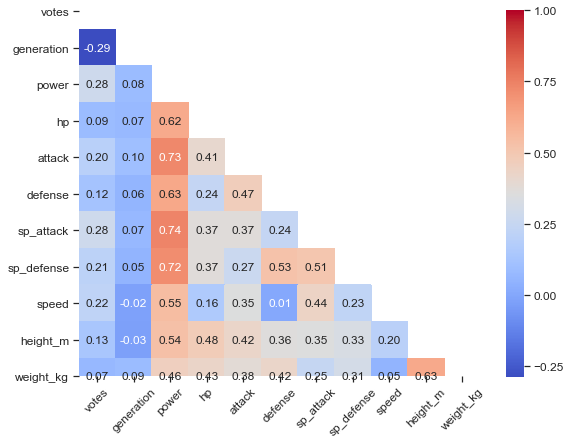

In [30]:
stats_corr = df_stats_reduced.corr(method='pearson')
mask = np.zeros_like(stats_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(1, 1, figsize=[9, 9])
sns.heatmap(stats_corr, annot=True, square=True, fmt= '.2f', cmap='coolwarm', mask=mask, cbar_kws={'shrink':0.75}, ax=ax)
ax.set_xticklabels(ax.get_yticklabels(), rotation=45)
plt.show()

The stats with the highest correlation are power and special attack (both with 0.28) and generation (with -0.29). Since power and special attack are strongly correlated beetween them, we will keep the former for future analysis. The other stats are only (very) weakly correlated with the number of votes.

Let's see how this looks visually with a little bit more of detail:

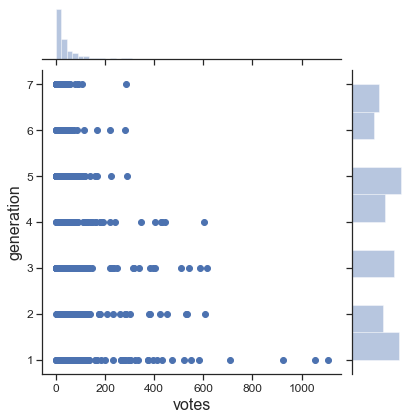

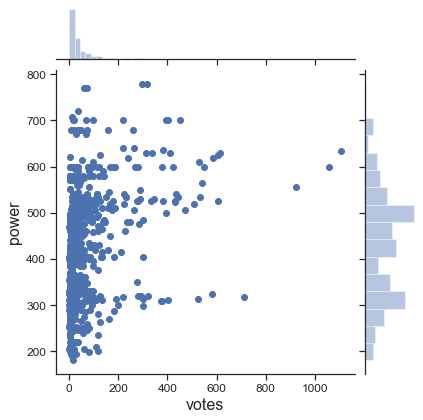

In [31]:
features = ['generation', 'power']
for feature in features:
    g = sns.jointplot('votes', feature, data=df_stats)
    plt.show()

Mmm, it looks like we have a lot of Pok&eacute;mon with low number of votes. Let's convert the votes to a logarithmic scale and do the same analysis:

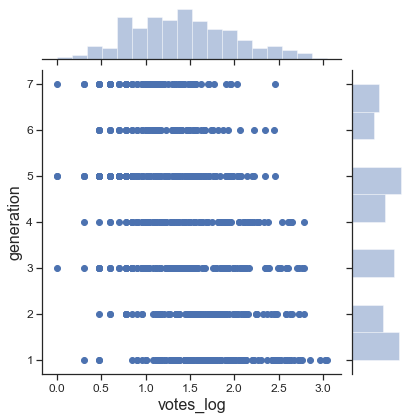

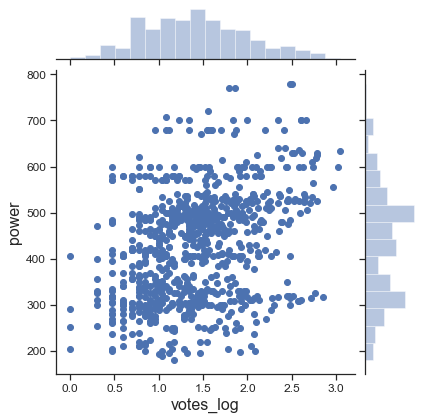

In [32]:
df_stats['votes_log'] = np.log10(df_stats['votes']+1)
features = ['generation', 'power']
for feature in features:
    g = sns.jointplot('votes_log', feature, data=df_stats)
    plt.show()

# Conclusions
There are a few interesting conclusions worth pointing out:
* There were [more votes for Pok&eacute;mon from earlier generations](#Average-votes-per-Pok&eacute;mon-per-generation). This is a very interesting result. Does nostalgia play an important role here? It is hard to say. It would be very interesting to have more information on the voters' profile (e.g., age). For instance, older fans could have more preference for Pok&eacute;mon with which they grew up with. Unfortunately, we don't have those data.
* It is no surprise that the Eevee family is [the most popular Pok&eacute;mon family](#Pok&eacute;mon-ranking-by-family), given that [Eevee is the Pokemon with the most evolutions](https://bulbapedia.bulbagarden.net/wiki/Eeveelution) (plus, let's face it, most of them are quite cool).
* The [Paretto principle](#Paretto-analysis) kinda works in this case: 20% of the Pok&eacute;mon received ~72% of the votes.
* It looks like the [best predictors of Pok&eacute;mon preference are generation and power](#Incorporating-Pok&eacute;mon-stats). Originally, I thought a Pok&eacute;mon's size (i.e., height or weight) could be a factor (maybe larger/smaller Pok&eacute;mon were more popoular because of their imponent/cute appearance), but it doesn't look like it. If we wished to build a model to predict Pok&eacute;mon preference, this would be our starting point (I will probably try to do so in the future!).
* Working with Pok&eacute;mon data is fun :)